In [ ]:
audio_path = "/home/julianallchin/github/luma/experiments/stems/Step 2 It - LYNY - SoundLoadMate.com/other.wav"

In [ ]:
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt


In [ ]:
# Load audio file
audio, sr = sf.read(audio_path)

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

print(f"Audio length: {len(audio)/sr:.2f} seconds")
print(f"Sample rate: {sr} Hz")


Audio length: 210.00 seconds
Sample rate: 44100 Hz


In [ ]:
# Extract segment from 30s to 50s
start_time = 47
end_time = 90.0
start_sample = int(start_time * sr)
end_sample = int(end_time * sr)
audio_segment = audio[start_sample:end_sample]

print(f"Segment length: {len(audio_segment)/sr:.2f} seconds")


Segment length: 43.00 seconds


In [ ]:
# Estimate pitch using librosa's pyin (Probabilistic YIN)
# fmin and fmax are typical ranges for bass frequencies (around 40-400 Hz)
# Using longer frame_length for better low-frequency detection
frame_length = 4096
hop_length = frame_length // 4  # Standard hop length

# Detect most prominent pitch over time
f0, voiced_flag, voiced_probs = librosa.pyin(audio_segment, 
                                             fmin=librosa.note_to_hz('C1'),  # ~32.7 Hz
                                             fmax=librosa.note_to_hz('C5'),  # ~523 Hz
                                             sr=sr,
                                             frame_length=frame_length,
                                             hop_length=hop_length,
                                             n_thresholds=100)

# Create time axis for the pitch estimates using the correct hop_length
times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length) + start_time

print(f"Pitch track length: {len(f0)} frames")
print(f"Time range: {times[0]:.2f}s to {times[-1]:.2f}s")
valid_frames = np.sum(~np.isnan(f0))
print(f"Detected pitch frames: {valid_frames}/{len(f0)} ({100*valid_frames/len(f0):.1f}%)")
if valid_frames > 0:
    valid_times = times[~np.isnan(f0)]
    print(f"Pitch detected from {valid_times[0]:.2f}s to {valid_times[-1]:.2f}s")


Pitch track length: 1852 frames
Time range: 47.00s to 89.98s
Detected pitch frames: 1376/1852 (74.3%)
Pitch detected from 47.00s to 89.98s


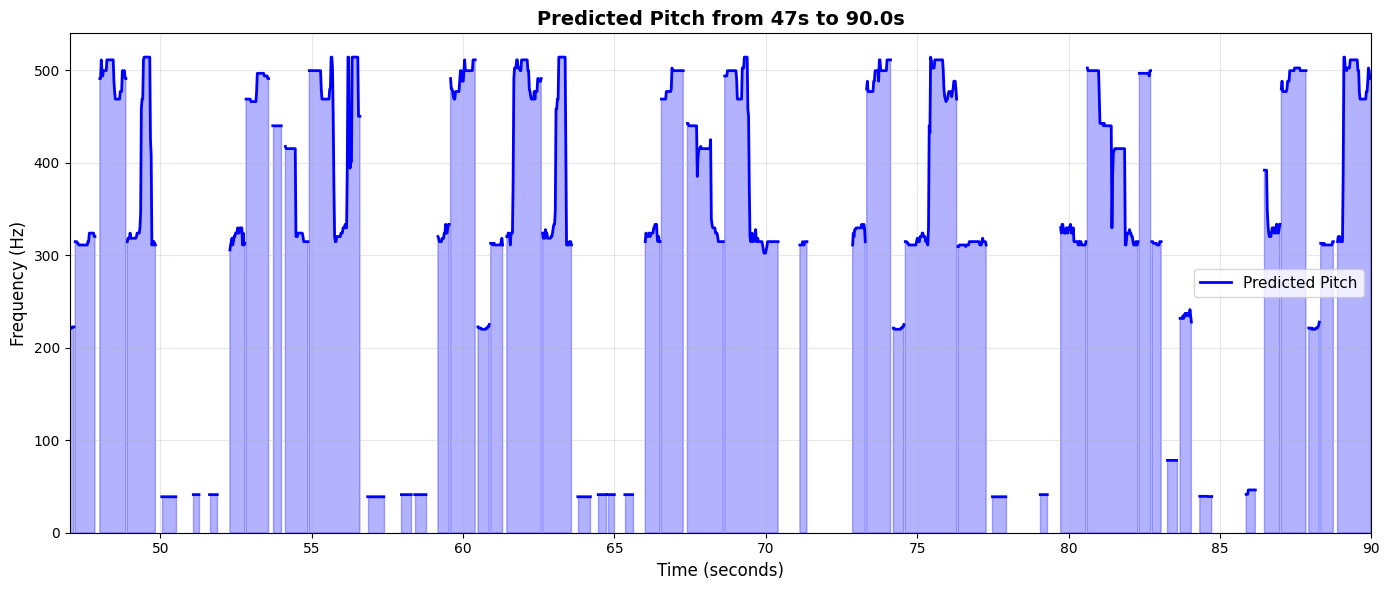


Pitch Statistics:
  Mean: 336.32 Hz
  Median: 323.96 Hz
  Min: 38.89 Hz
  Max: 514.26 Hz
  Detected frames: 1376/1852 (74.3%)


In [ ]:
# Plot the detected pitch (no gap filling)
fig, ax = plt.subplots(figsize=(14, 6))

# Plot pitch track (NaN values will be automatically skipped)
masked_f0 = np.ma.masked_where(np.isnan(f0), f0)
ax.plot(times, masked_f0, linewidth=2, color='blue', label='Predicted Pitch')

# Fill area under the curve for better visualization
ax.fill_between(times, masked_f0, alpha=0.3, color='blue')

# Formatting
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_title(f'Predicted Pitch from {start_time}s to {end_time}s', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(start_time, end_time)

# Set y-axis to show reasonable range
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print some statistics
valid_f0 = f0[~np.isnan(f0)]
if len(valid_f0) > 0:
    print(f"\nPitch Statistics:")
    print(f"  Mean: {np.mean(valid_f0):.2f} Hz")
    print(f"  Median: {np.median(valid_f0):.2f} Hz")
    print(f"  Min: {np.min(valid_f0):.2f} Hz")
    print(f"  Max: {np.max(valid_f0):.2f} Hz")
    print(f"  Detected frames: {len(valid_f0)}/{len(f0)} ({100*len(valid_f0)/len(f0):.1f}%)")


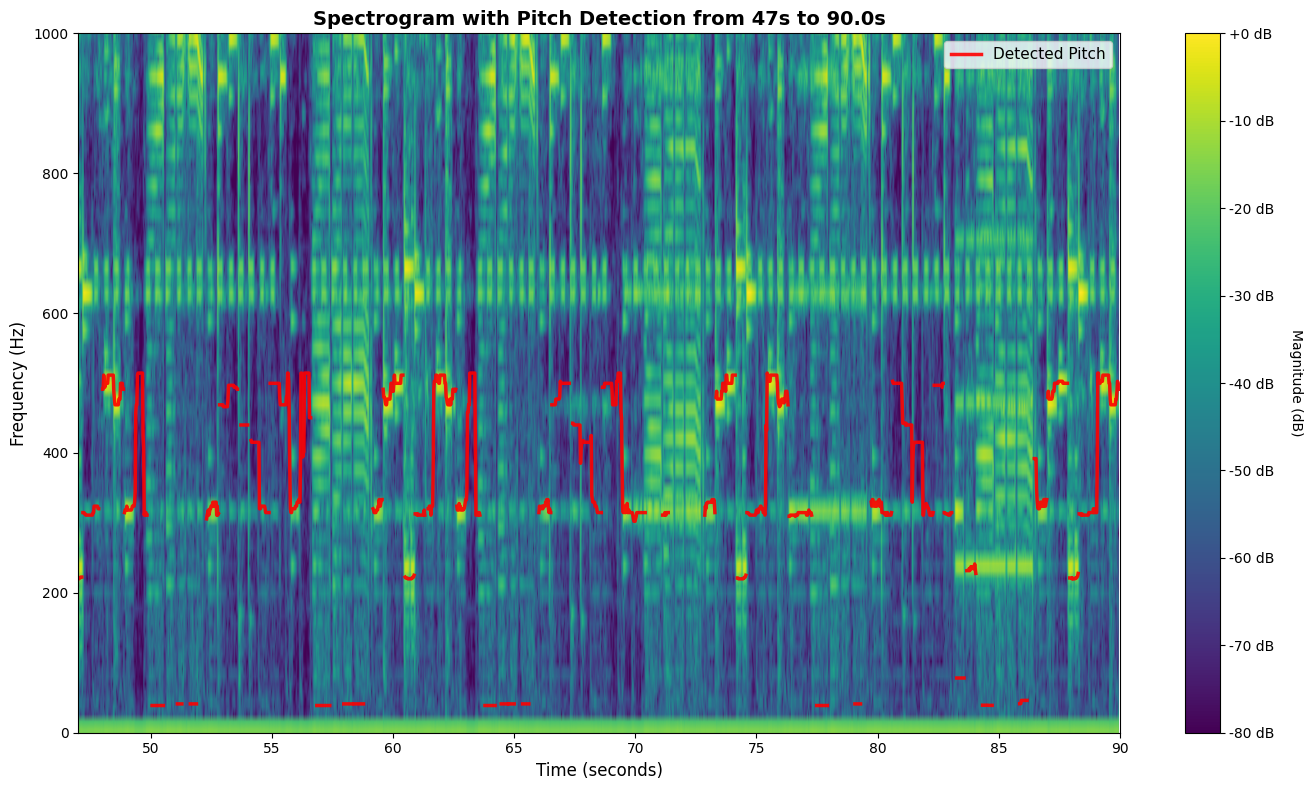

In [ ]:
# Create spectrogram of the time window
D = librosa.stft(audio_segment, hop_length=hop_length, n_fft=frame_length)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Get time axis for spectrogram
times_spec = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length) + start_time

# Get frequency axis
freqs = librosa.fft_frequencies(sr=sr, n_fft=frame_length)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Display spectrogram
img = ax.imshow(S_db, aspect='auto', origin='lower', 
                extent=[times_spec[0], times_spec[-1], freqs[0], freqs[-1]],
                cmap='viridis', interpolation='bilinear')

# Overlay the detected pitch on top
masked_f0 = np.ma.masked_where(np.isnan(f0), f0)
ax.plot(times, masked_f0, linewidth=2.5, color='red', label='Detected Pitch', alpha=0.9)

# Add colorbar with dB scale
cbar = plt.colorbar(img, ax=ax, format='%+2.0f dB')
cbar.set_label('Magnitude (dB)', rotation=270, labelpad=20)

# Labels and title
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_title(f'Spectrogram with Pitch Detection from {start_time}s to {end_time}s', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim(start_time, end_time)
ax.set_ylim(0, 1000)  # Focus on lower frequencies for bass

plt.tight_layout()
plt.show()
